In [2]:
#%pylab qt5
#%precision 5
#set_printoptions(precision=5)
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (11, 7)
import networkx as nx
import numpy as np
import scipy
import matplotlib.cm as cm
import matplotlib.pyplot as plt

To see how the karate club graph looks like:

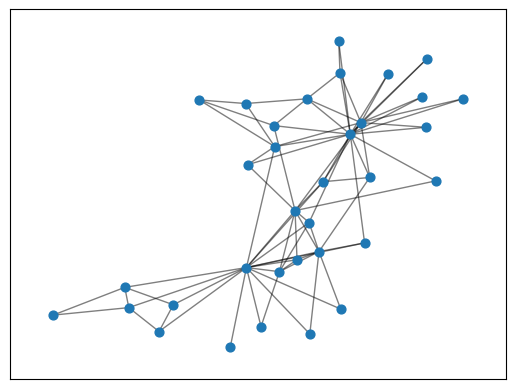

In [37]:
# load the karate club graph
G = nx.karate_club_graph()
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
#cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
#nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_nodes(G, pos, node_size=40)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

Defining some functions: (don't need init at the moment)

In [6]:
def phi(dist):
    """
    threshold function
    """
    if dist<1:
        res=1-dist
    else:
        res=0
    return res

In [3]:
def init():
    """
    Chooses a graph and assigns a number between -1 and 1 to each vertex
    """
    G = nx.karate_club_graph()
    for i in range(G.number_of_nodes()):
        G.nodes[i]['startval']=2*np.random.random()-1
    return G

In [7]:
def abl(t,arr):
    """
    The derivative function for solving the dynamics
    """
    inc=nx.incidence_matrix(G,oriented=True).toarray()
    v=[]
    for k in nx.edges(G):
        v=np.append(v,[phi(abs(arr[k[0]]-arr[k[1]]))])
    return -np.dot(np.matmul(np.matmul(inc,np.diag(v)),np.transpose(inc)),arr)

So now let us do one self-contained cell for solving the dynamics:

In [91]:
def sol(G):
    """
    solves the dynamics for a given graph and a random starting distribution
    """
    y=[] #start value
    for i in range(G.number_of_nodes()):
        y=np.append(y,3*np.random.random()-1.5) #ok, range 2 scheint zu niedrig zu sein, range 3 ist schon besser...
    return scipy.integrate.solve_ivp(abl,[0,100],y,t_eval=[100])

Now want to cluster the nodes by their final value. The following can be used to calculate clusters given a solution vector:

In [132]:
sollim=sol(G)
cluster=np.zeros(G.number_of_nodes())
for i in range(G.number_of_nodes()):
    if cluster[i]==0:
        cluster[i]=np.max(cluster)+1
        for k in range(i,G.number_of_nodes()):
            if abs(sollim.y[i][0]-sollim.y[k][0])<0.01:
                cluster[k]=cluster[i]
for l in G.nodes():
    if np.min([cluster[k] for k in G.neighbors(l)])==np.max([cluster[k] for k in G.neighbors(l)]):
        cluster[l]=cluster[int([cluster[k] for k in G.neighbors(l)][0])]
print(cluster)

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/3994252088.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()


[1. 2. 1. 1. 3. 4. 4. 1. 2. 2. 1. 2. 2. 2. 1. 1. 3. 2. 1. 1. 1. 2. 1. 1.
 1. 2. 1. 2. 2. 2. 1. 2. 2. 2.]


Now we would like to represent such a partition:
(to get an idea of single results, one can run the previous and next cell a few times)

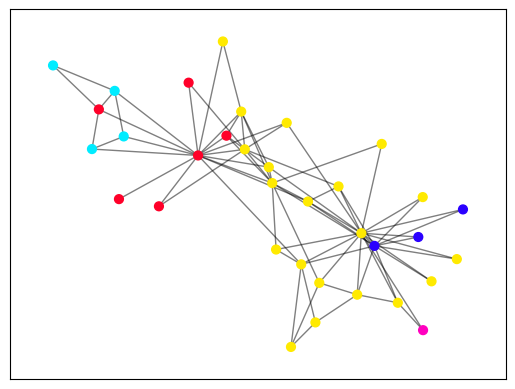

In [95]:
cmap = cm.get_cmap('gist_rainbow', int(np.max(cluster)+1))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=40, cmap=cmap, node_color=cluster)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

Next, we would like to have many runs and calculate an "average". There are two versions for this:
Lets first try to compare entire partitions - although I'm not sure if there will be a repetition at all, due to many outliers (no repetition for 11 samples - duration on my laptop about 2.2s per sample)

First combine solving with calculating cluster (Could be improved by checking that indeed after the given time nothing happens any more, but in example cases that was the case, i.e. if on some edge, the difference is between 0.01 and 1, calculate longer and can also change 0.01 to 0.001 then - doesn't improve much though).

In [47]:
def part(G):
    """
    Calculates a partition of a given graph
    """
    y=[]
    for i in range(G.number_of_nodes()):
        y=np.append(y,3*np.random.random()-1.5)
    sollim=scipy.integrate.solve_ivp(abl,[0,100],y,t_eval=[100])
    cluster=np.zeros(G.number_of_nodes())
    for i in range(G.number_of_nodes()):
        if cluster[i]==0:
            cluster[i]=np.max(cluster)+1
            for k in range(i,G.number_of_nodes()):
                if abs(sollim.y[i][0]-sollim.y[k][0])<0.01:
                    cluster[k]=cluster[i]
    return cluster

In [ ]:
G=nx.karate_club_graph()
res=np.array([[part(G),1]])
for i in range(10):
    p=part(G)
    for k in range(len(res[:,0])):
        b=0
        if (res[k,0]==p).all():
            res[k,1]=res[k,1]+1
            b=1
    if b==0:
        res=np.vstack([res,[p,1]])
    print(i)
print(np.max(res[:,1]))

Maybe one could improve the partition by assigning a vertex which is only connected to vertices of one cluster to this cluster (repeating until there is no such vertex any more).

Second idea: compare families of vertices among different partitions - maybe there are large clusters that are formed in several partitions; just some outliers make the partitions different

In [109]:
G=nx.karate_club_graph()
p=part(G)
res=np.array([[np.nonzero(p==1)[0],1]])
for k in range(1,int(np.max(p))):
    res=np.vstack([res,[np.nonzero(p==k+1)[0],1]])
for i in range(9):
    p=part(G)
    for l in range(int(np.max(p))):
        v=np.nonzero(p==l+1)[0]
        for k in range(len(res[:,0])):
            b=0
            if len(res[k,0])==len(v) and (res[k,0]==v).all():
                res[k,1]=res[k,1]+1
                b=1
        if b==0:
            res=np.vstack([res,[v,1]])
    print(i)
print(np.max(res[:,1]))

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/3994252088.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()
/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/4068360861.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res=np.array([[np.nonzero(p==1)[0],1]])
/Users/arne/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


0
1
2
3
4
5
6
7
8
4


In [110]:
res

array([[array([ 0, 11, 12, 14, 18, 19, 22, 23, 26, 27, 29, 30, 31, 32, 33]),
        1],
       [array([ 1,  2,  3,  7,  8,  9, 13, 17, 21, 28]), 1],
       [array([ 4,  5,  6, 10, 16]), 1],
       [array([15]), 3],
       [array([20]), 1],
       [array([24, 25]), 1],
       [array([0]), 2],
       [array([ 1,  2,  4,  6,  7,  8,  9, 11, 12, 13, 15, 16, 18, 19, 21, 22, 23,
               24, 25, 28, 30, 31, 33])                                           ,
        1],
       [array([3]), 2],
       [array([ 5, 10]), 1],
       [array([14, 20, 26, 29, 32]), 1],
       [array([17]), 4],
       [array([27]), 1],
       [array([ 0,  1,  3,  4,  7, 11, 13, 19, 21]), 1],
       [array([ 2,  8, 14, 18, 20, 22, 24, 26, 27, 30, 31, 32]), 1],
       [array([ 5,  6, 10, 33]), 1],
       [array([9]), 3],
       [array([12]), 1],
       [array([15]), 2],
       [array([16]), 2],
       [array([17]), 3],
       [array([23, 25, 29]), 1],
       [array([28]), 1],
       [array([ 0,  2,  4,  5,  6,  7,

In [133]:
[cluster[k] for k in G.neighbors(2)]

[1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]